<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [3]:
import datetime
import logging
import os
import pickle
import sys
import time
import functools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()
import progressbar
import qutip
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.logging_utils
import scipy
import seaborn as sns

if './src/' not in sys.path:
    sys.path.append('./src/')
import rabi_model
import lmg_model
import optimization
import protocol_ansatz as protocol_ansatz
from utils import ground_state

sns.set()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we visualize the protocols obtained from the optimisations in different scenarios.

In [ ]:
def display_optimization_result_dynamics_lmg(filename, solution_index, num_spins=50, g_target=1.):
    tf, fid, y0, t1, y1 = pd.read_csv(filename, index_col=0).iloc[solution_index]
    print('Total time: {}\nFidelity: {}'.format(tf, fid))

    protocol = protocol_ansatz.DoubleBangProtocolAnsatz()
    protocol.fill_hyperpar_value(tf=tf)
    fun = protocol.time_dependent_fun([y0, t1, y1])

    Hfree = lmg_model.LMG_free_term(num_spins=num_spins)
    Hint = lmg_model.LMG_interaction_term(num_spins=num_spins)
    Htarget = lmg_model.LMG_full_hamiltonian(num_spins=num_spins, g_value=g_target)
    initial_state = ground_state(Hfree)
    target_state = ground_state(Htarget)
    tlist = np.linspace(0, tf, 100)

    output_states = qutip.mesolve(H=[Hfree, [Hint, fun]], rho0=initial_state, tlist=tlist).states

    fids_target = [qutip.fidelity(output_state, target_state) for output_state in output_states]
    fids_initial = [qutip.fidelity(output_state, initial_state) for output_state in output_states]
    variances = []
    for t, state in zip(tlist, output_states):
        H = Hfree + fun(t) * Hint
        variances.append(qutip.expect(H**2, state) - qutip.expect(H, state)**2)


    fig, axs = plt.subplots(2, 2, figsize=(20, 8))
    axs[0, 0].plot(tlist, fids_target);
    axs[0, 0].set_title('Fidelity wrt target state')
    axs[0, 1].plot(tlist, fids_initial)
    axs[0, 1].set_title('Fidelity wrt initial state')
    axs[1, 0].plot(tlist, variances)
    axs[1, 0].set_title(r'Instantaneous variance $\sigma_H^2$')
    axs[1, 1].plot(tlist, [fun(t) for t in tlist])
    axs[1, 1].set_title('Protocol')
    plt.tight_layout()

Total time: 0.8676767676767676
Fidelity: 0.9988566772489864


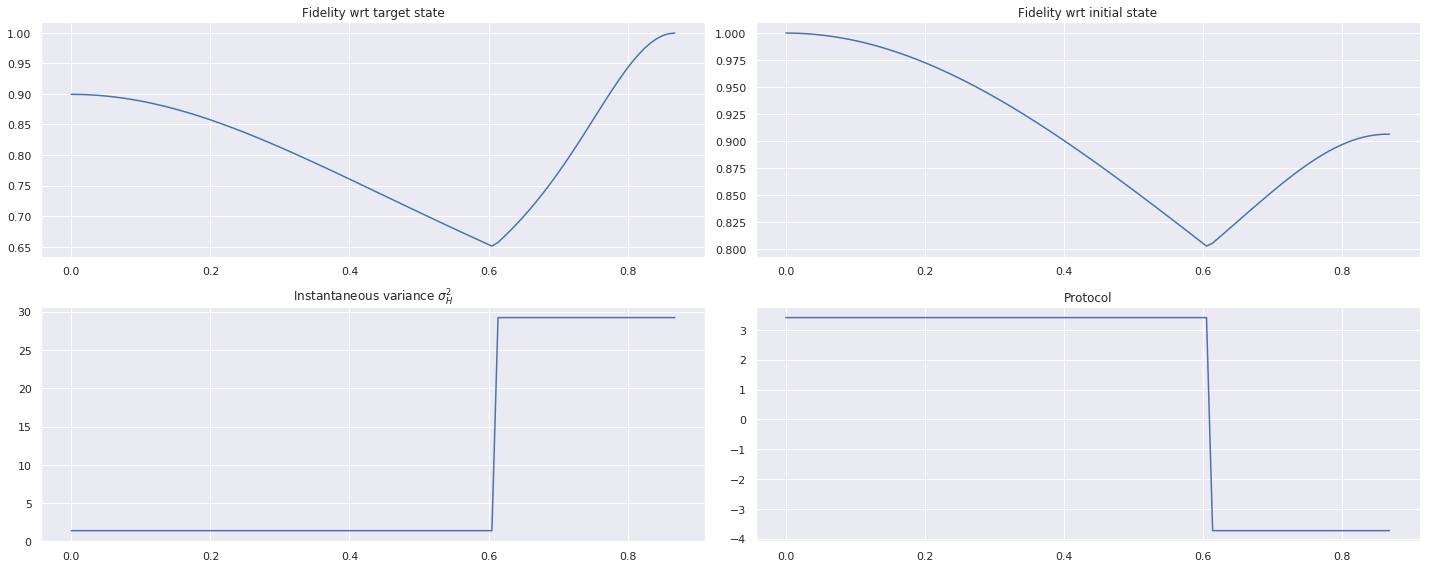

In [18]:
def _():
    num_spins = 50
    filename = './results/rabi_and_lmg_optimizations_different_constraints_20190228/lmg_doublebang_powell_bounds5.csv'
    tf, fid, y0, t1, y1 = pd.read_csv(filename, index_col=0).iloc[40]
    print('Total time: {}\nFidelity: {}'.format(tf, fid))

    protocol = protocol_ansatz.DoubleBangProtocolAnsatz()
    protocol.fill_hyperpar_value(tf=tf)
    fun = protocol.time_dependent_fun([y0, t1, y1])

    Hfree = lmg_model.LMG_free_term(num_spins=num_spins)
    Hint = lmg_model.LMG_interaction_term(num_spins=num_spins)
    Htarget = lmg_model.LMG_full_hamiltonian(num_spins=num_spins, g_value=1.)
    initial_state = ground_state(Hfree)
    target_state = ground_state(Htarget)
    tlist = np.linspace(0, tf, 100)

    output_states = qutip.mesolve(H=[Hfree, [Hint, fun]], rho0=initial_state, tlist=tlist).states

    fids_target = [qutip.fidelity(output_state, target_state) for output_state in output_states]
    fids_initial = [qutip.fidelity(output_state, initial_state) for output_state in output_states]
    variances = []
    for t, state in zip(tlist, output_states):
        H = Hfree + fun(t) * Hint
        variances.append(qutip.expect(H**2, state) - qutip.expect(H, state)**2)


    fig, axs = plt.subplots(2, 2, figsize=(20, 8))
    axs[0, 0].plot(tlist, fids_target);
    axs[0, 0].set_title('Fidelity wrt target state')
    axs[0, 1].plot(tlist, fids_initial)
    axs[0, 1].set_title('Fidelity wrt initial state')
    axs[1, 0].plot(tlist, variances)
    axs[1, 0].set_title(r'Instantaneous variance $\sigma_H^2$')
    axs[1, 1].plot(tlist, [fun(t) for t in tlist])
    axs[1, 1].set_title('Protocol')
    plt.tight_layout()
_()

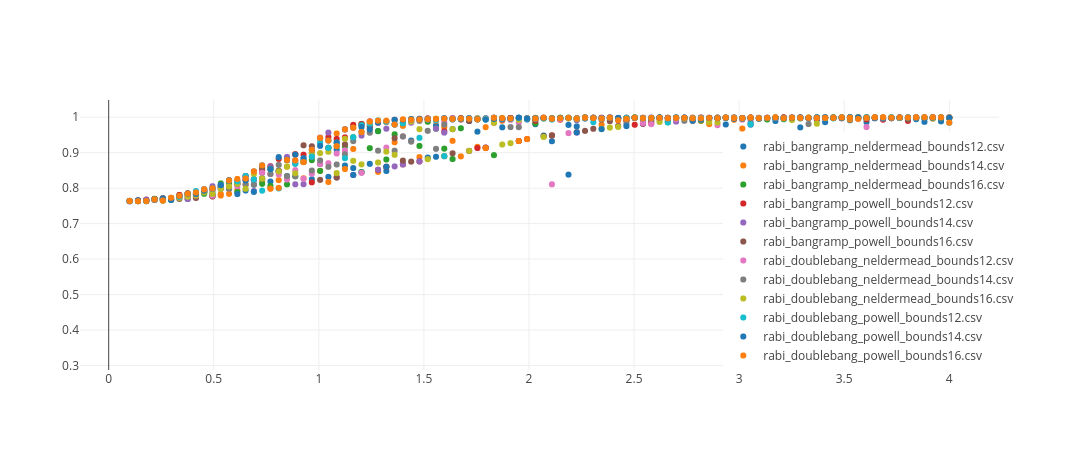

In [15]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_different_constraints_20190228/rabi*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

Total time: 1.6757575757575758
Fidelity: 0.9951699873117592


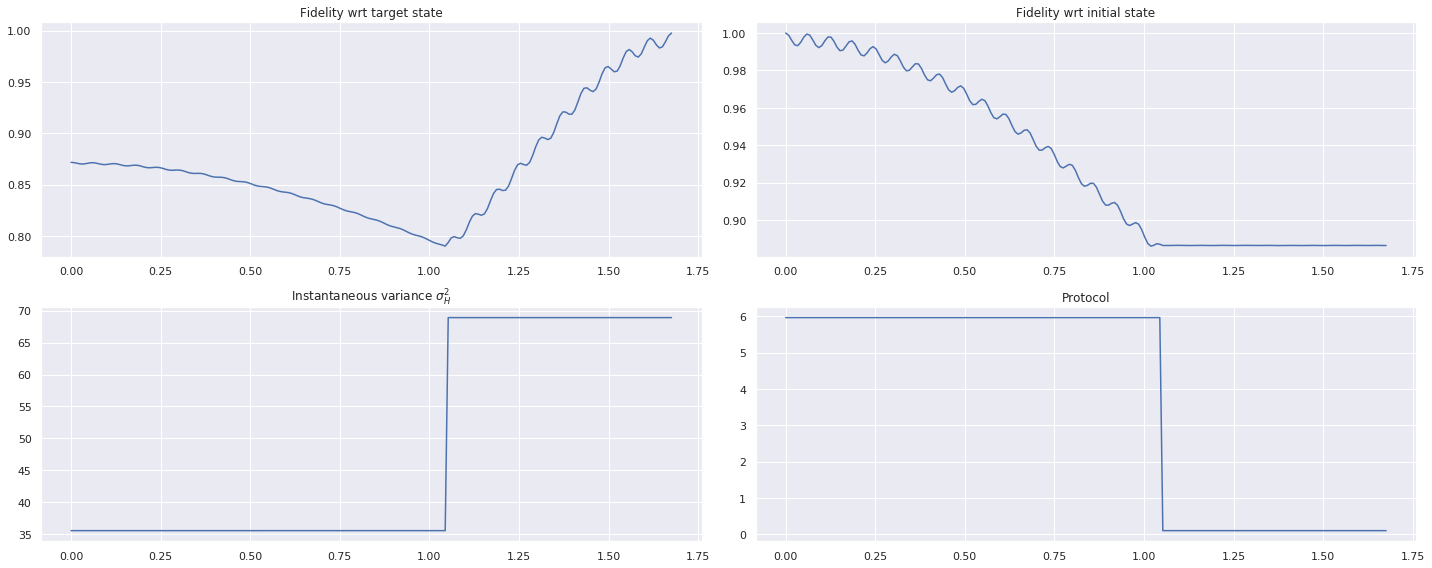

In [20]:
def _():
    N = 100
    Omega = N
    omega_0 = 1.
    lambda_c = np.sqrt(Omega * omega_0) / 2.
    filename = './results/rabi_and_lmg_optimizations_different_constraints_20190228/rabi_doublebang_powell_bounds14.csv'
    tf, fid, y0, t1, y1 = pd.read_csv(filename, index_col=0).iloc[40]
    print('Total time: {}\nFidelity: {}'.format(tf, fid))

    protocol = protocol_ansatz.DoubleBangProtocolAnsatz()
    protocol.fill_hyperpar_value(tf=tf)
    fun = protocol.time_dependent_fun([y0, t1, y1])

    Hfree = rabi_model.QRM_free_term(N=N, Omega=Omega, omega_0=omega_0)
    Hint = rabi_model.QRM_interaction_term(N=N)
    Htarget = rabi_model.QRM_full(N=N, Omega=Omega, omega_0=omega_0, lambda_=lambda_c)
    initial_state = ground_state(Hfree)
    target_state = ground_state(Htarget)
    tlist = np.linspace(0, tf, 200)

    output_states = qutip.mesolve(H=[Hfree, [Hint, fun]], rho0=initial_state, tlist=tlist).states

    fids_target = [qutip.fidelity(output_state, target_state) for output_state in output_states]
    fids_initial = [qutip.fidelity(output_state, initial_state) for output_state in output_states]
    variances = []
    for t, state in zip(tlist, output_states):
        H = Hfree + fun(t) * Hint
        variances.append(qutip.expect(H**2, state) - qutip.expect(H, state)**2)


    fig, axs = plt.subplots(2, 2, figsize=(20, 8))
    axs[0, 0].plot(tlist, fids_target);
    axs[0, 0].set_title('Fidelity wrt target state')
    axs[0, 1].plot(tlist, fids_initial)
    axs[0, 1].set_title('Fidelity wrt initial state')
    axs[1, 0].plot(tlist, variances)
    axs[1, 0].set_title(r'Instantaneous variance $\sigma_H^2$')
    axs[1, 1].plot(tlist, [fun(t) for t in tlist])
    axs[1, 1].set_title('Protocol')
    plt.tight_layout()
_()

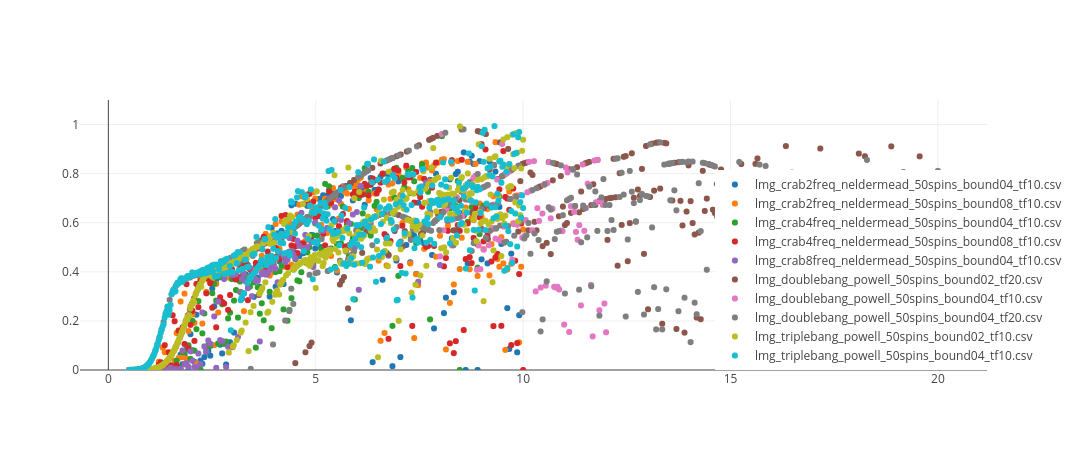

In [21]:
def _():
    # load data
    datafiles = !ls ./results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/lmg*.csv
    traces = []
    for file in datafiles:
        df = pd.read_csv(file, index_col=0)
        # plot
        traces.append(go.Scatter(
            x=df['tf'], y=df['fid'],
            mode='markers', name=os.path.split(file)[-1]
        ))
    layout = go.Layout(legend=dict(x=.7, y=0), yaxis=dict(range=[0, 1.1]))
    plotly.offline.iplot(go.Figure(data=traces, layout=layout))
_()

Total time: 2.4548872180451133
Fidelity: 0.396033782331546


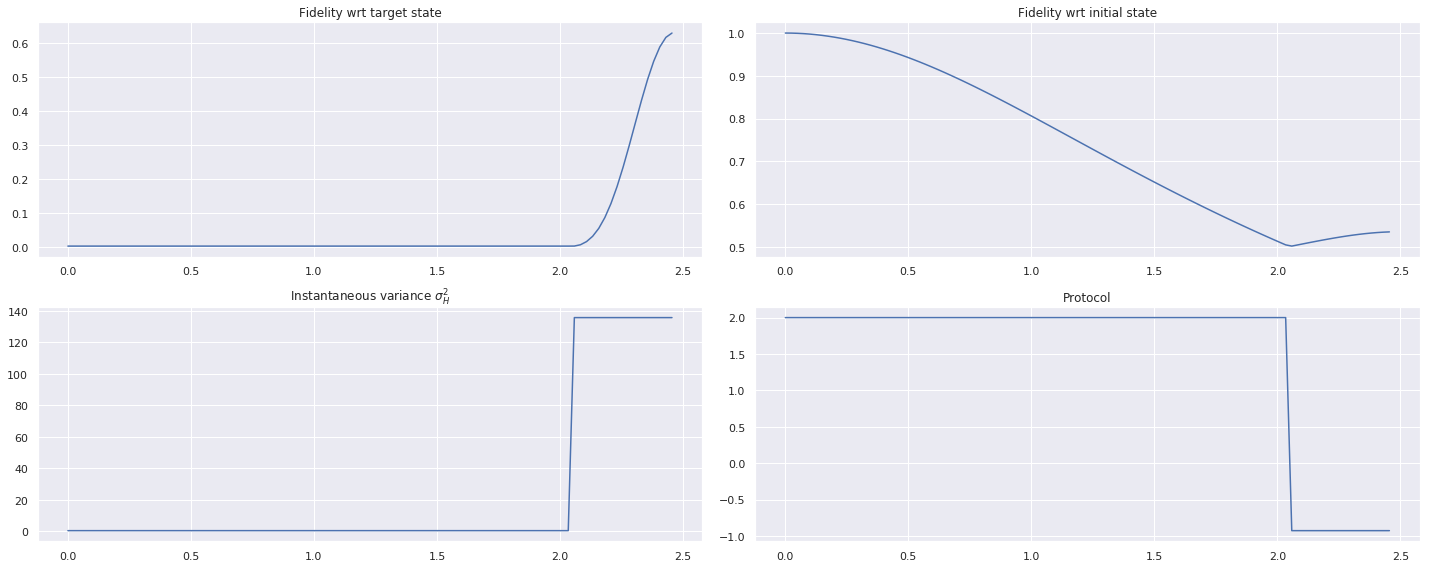

In [45]:
display_optimization_result_dynamics_lmg(
    './results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/lmg_doublebang_powell_50spins_bound02_tf20.csv',
    solution_index=40, num_spins=50, g_target=2.
)

Total time: 8.466165413533831
Fidelity: 0.6914367152506657


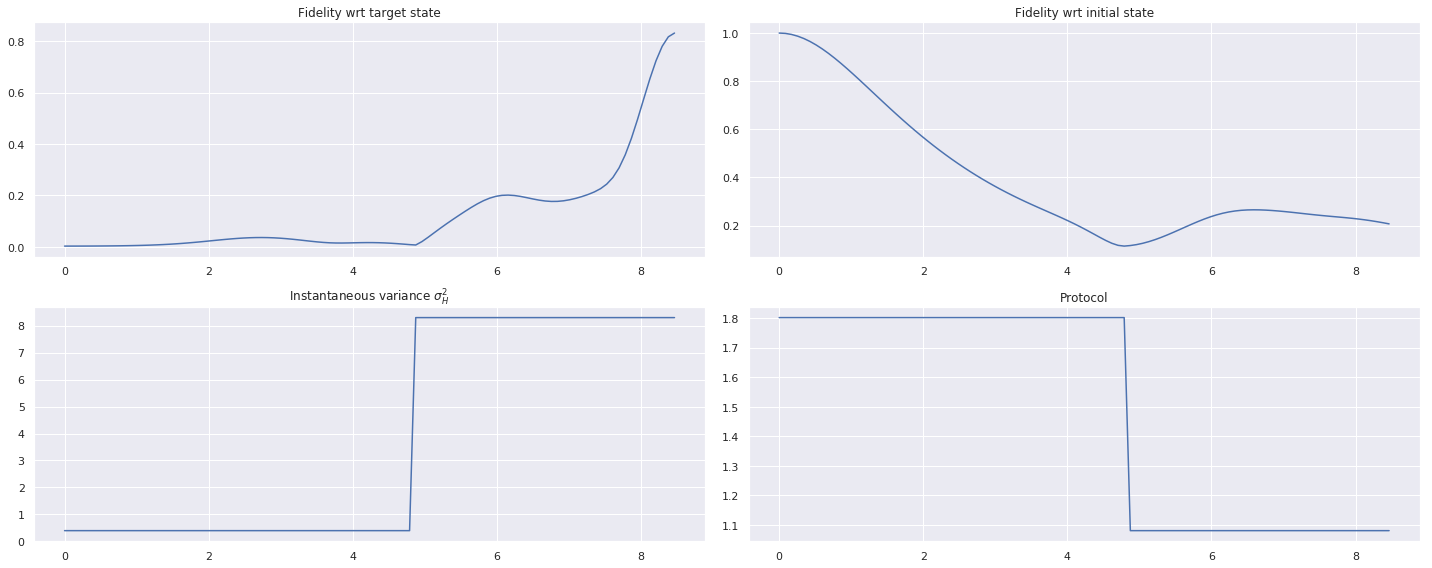

In [44]:
display_optimization_result_dynamics_lmg(
    './results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/lmg_doublebang_powell_50spins_bound02_tf20.csv',
    solution_index=163, num_spins=50, g_target=2.
)

Total time: 8.515037593984962
Fidelity: 0.9802002599750584


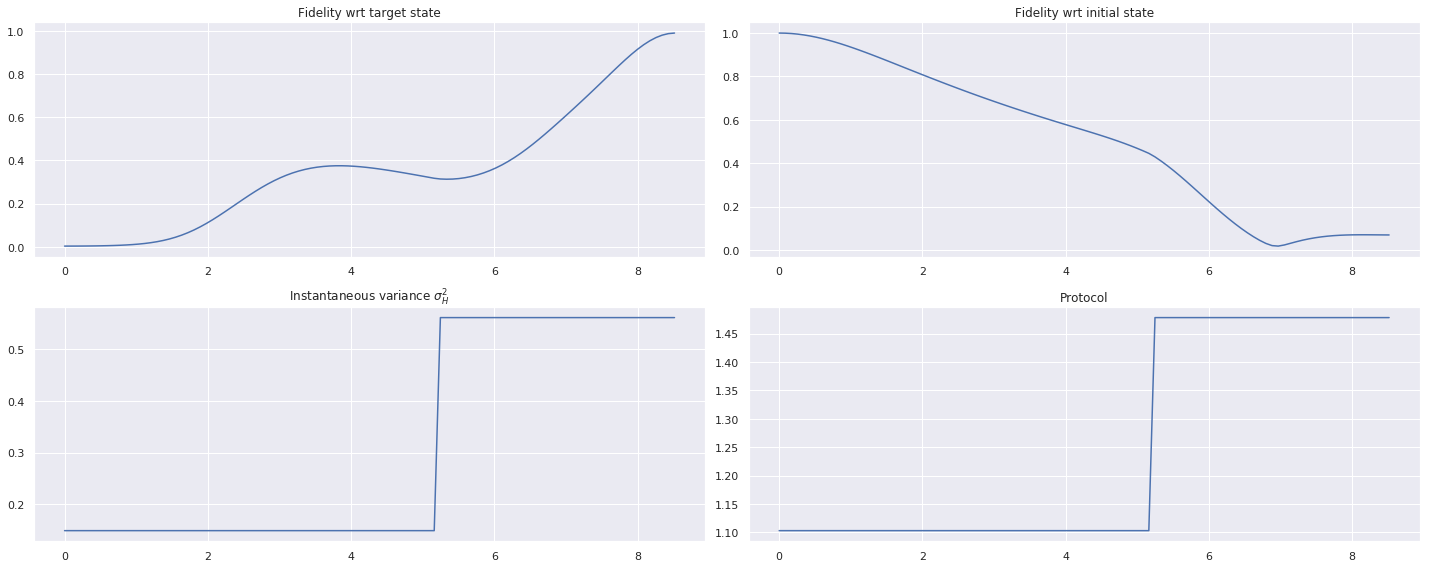

In [40]:
display_optimization_result_dynamics_lmg(
    './results/rabi_and_lmg_optimizations_crossingcriticalphase_20190305/lmg_doublebang_powell_50spins_bound02_tf20.csv',
    solution_index=164, num_spins=50, g_target=2.
)